## R code for propensity score matching for Amazon reviews

In [36]:
library('ggplot2')
#theme (panel.background = element_rect(width = 3))
library( tidyverse )
library( haven )
library( lmtest )
library( cobalt )
library( sandwich )

In [37]:
df <- read.csv("C:/Users/lliu9/Desktop/Amazon Reviews/New_Electronics/keyboard_data.csv")

In [38]:
head(df)

overall vote verified
1 5       1113 1       
2 5         16 1       
3 4         11 1       
4 5         NA 1       
5 5         NA 1       
6 5         NA 1       
  reviewText                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

### Logit score

In [39]:
names(df)

[1] "overall"         "vote"            "verified"        "reviewText"     
 [5] "summary"         "unixReviewTime"  "Topic1"          "Topic2"         
 [9] "Topic3"          "Topic4"          "Topic5"          "imagenum"       
[13] "nameverified"    "Sentiment"       "Length"          "Sentences"      
[17] "Flesch"          "Days"            "verified_option" "Retail"         
[21] "vote_fillna"

In [40]:
nrow(df)

[1] 2567

In [41]:
summary(df)

    overall           vote            verified          reviewText  
 Min.   :1.000   Min.   :   2.00   Min.   :0.0000   good     :   5  
 1st Qu.:4.000   1st Qu.:   2.00   1st Qu.:1.0000   great    :   5  
 Median :5.000   Median :   3.00   Median :1.0000   Excellent:   4  
 Mean   :4.206   Mean   :  16.41   Mean   :0.8629   love it  :   4  
 3rd Qu.:5.000   3rd Qu.:   5.00   3rd Qu.:1.0000   Love it. :   3  
 Max.   :5.000   Max.   :1113.00   Max.   :1.0000   fine     :   2  
                 NA's   :2393                       (Other)  :2544  
               summary        unixReviewTime     Topic1           Topic2       
 Five Stars        : 278   2013-01-23:   6   Min.   :0.4640   Min.   :0.03440  
 Four Stars        :  38   2014-08-07:   6   1st Qu.:0.4797   1st Qu.:0.03707  
 Great Keyboard    :  22   2015-01-01:   6   Median :0.4843   Median :0.03760  
 Great keyboard    :  19   2015-02-11:   6   Mean   :0.4845   Mean   :0.03846  
 Three Stars       :  15   2013-04-06:   5   3rd

In [42]:
prop.model <- glm( verified ~ Topic1 + Topic2 + Topic3 + Topic4 + Topic5 + 
                  imagenum + nameverified + Sentiment + Length + Sentences + 
                  Flesch + Days + verified_option + Retail,
                   family = binomial( link = "logit" ), data = df )
summary( prop.model )


Call:
glm(formula = verified ~ Topic1 + Topic2 + Topic3 + Topic4 + 
    Topic5 + imagenum + nameverified + Sentiment + Length + Sentences + 
    Flesch + Days + verified_option + Retail, family = binomial(link = "logit"), 
    data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5882   0.3328   0.4124   0.5148   2.1378  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -2.044e+04  9.490e+03  -2.154 0.031272 *  
Topic1           2.043e+04  9.491e+03   2.153 0.031338 *  
Topic2           2.040e+04  9.490e+03   2.150 0.031574 *  
Topic3           2.044e+04  9.490e+03   2.154 0.031245 *  
Topic4           2.049e+04  9.490e+03   2.159 0.030842 *  
Topic5           2.050e+04  9.490e+03   2.160 0.030764 *  
imagenum        -4.655e-03  4.933e-03  -0.944 0.345350    
nameverified    -2.583e-03  2.277e-01  -0.011 0.990948    
Sentiment        2.872e-01  1.054e-01   2.725 0.006429 ** 
Length          -1.835e-03  1.241e-03  -1.

In [43]:
# Logit Scores
df$logit <- predict(prop.model, type = "link" )

In [44]:
# Probability of Treatment
df$pred <- predict( prop.model, type = "response" )

### Identify common support

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


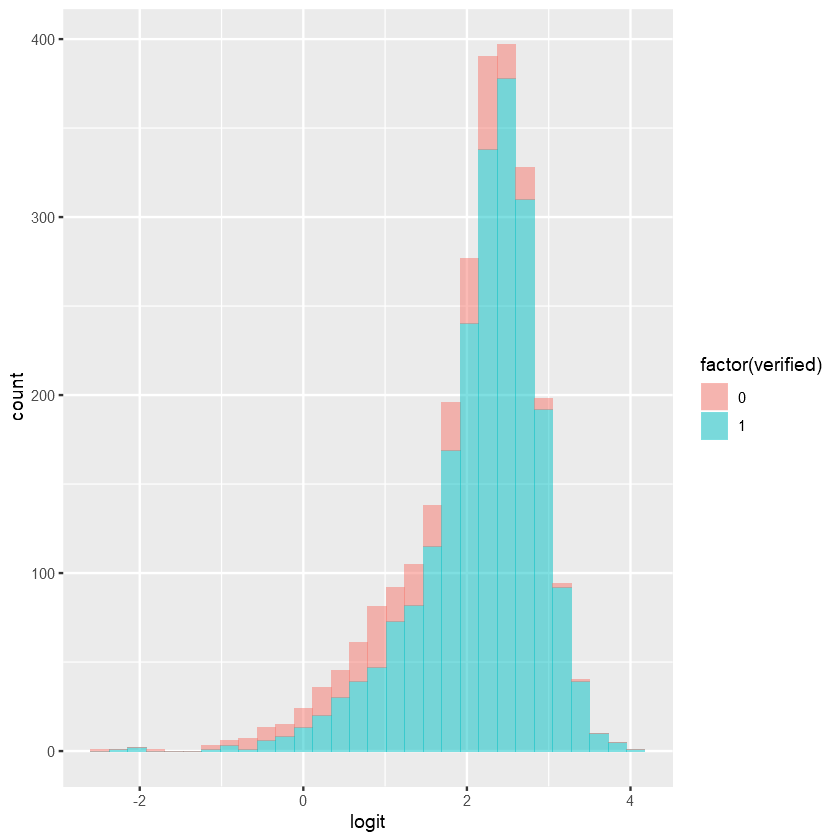

In [45]:
ggplot( df ) +
  geom_histogram( aes( x = logit, fill = factor( verified ) ), alpha = 0.5 )

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


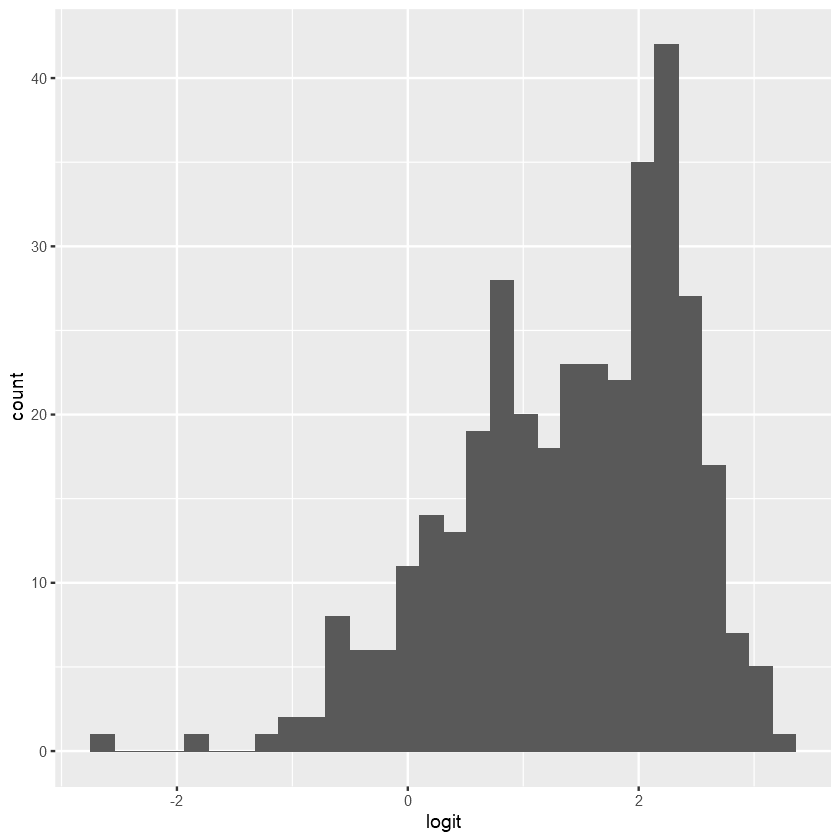

In [46]:
ggplot( filter( df, verified == 0 ) ) +
  geom_histogram( aes( x = logit ) )

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


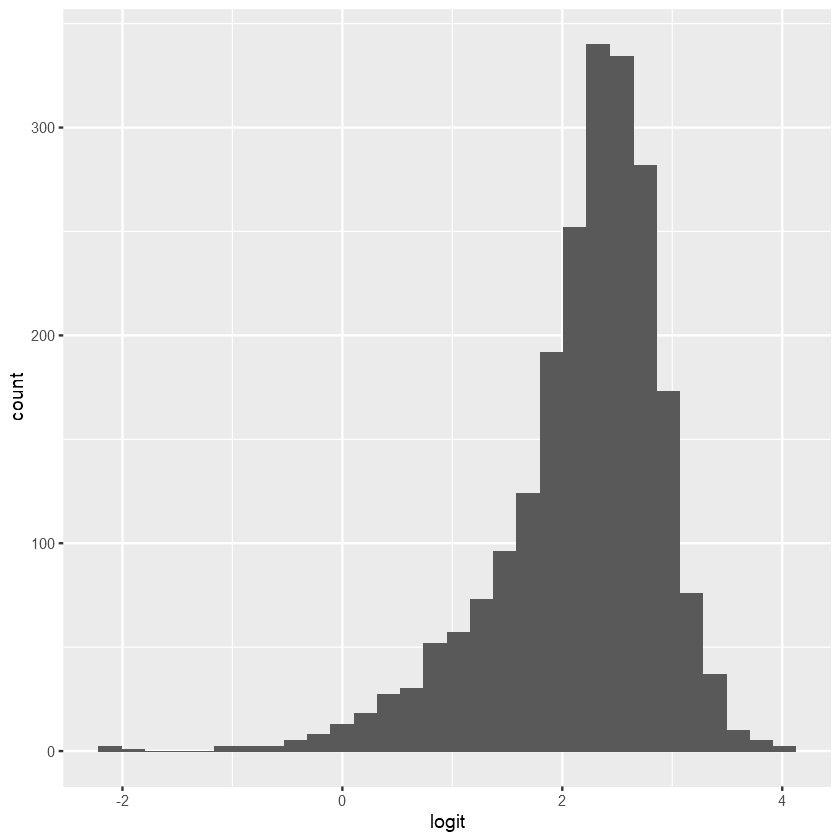

In [47]:
ggplot( filter( df, verified == 1 ) ) +
  geom_histogram( aes( x = logit ) )

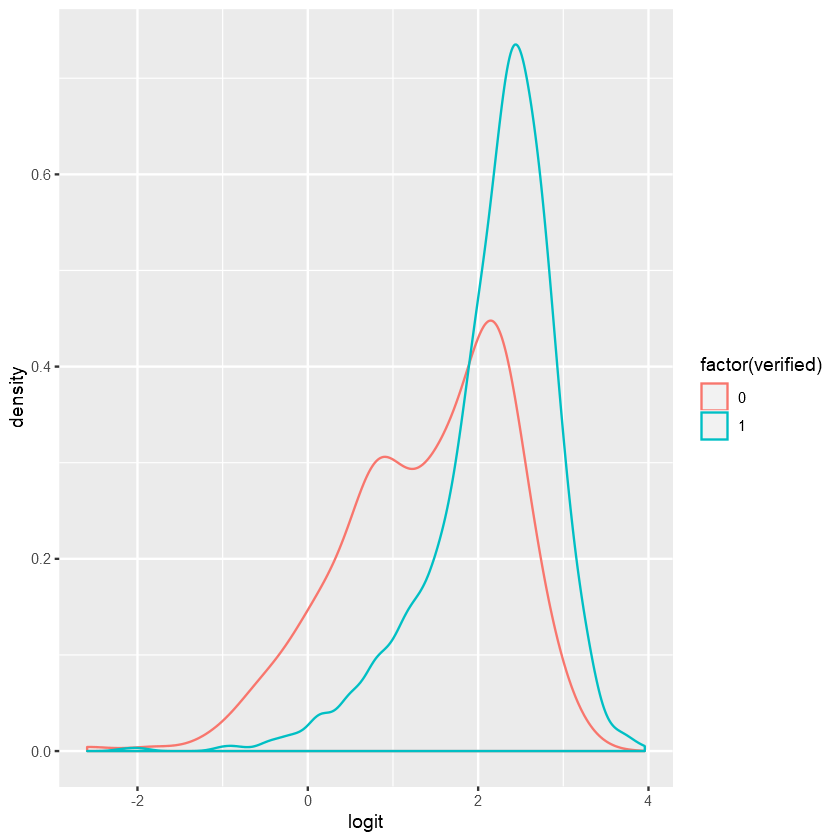

In [48]:
ggplot( df ) +
  geom_density( aes( x = logit, color = factor( verified ) ), alpha = 0.5 )

In [49]:
summary( filter( df, verified == 0 )$logit )
summary( filter( df, verified == 1 )$logit )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-2.5911  0.7576  1.5626  1.3981  2.1769  3.3136 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -2.178   1.850   2.323   2.178   2.663   3.957 

### Matching

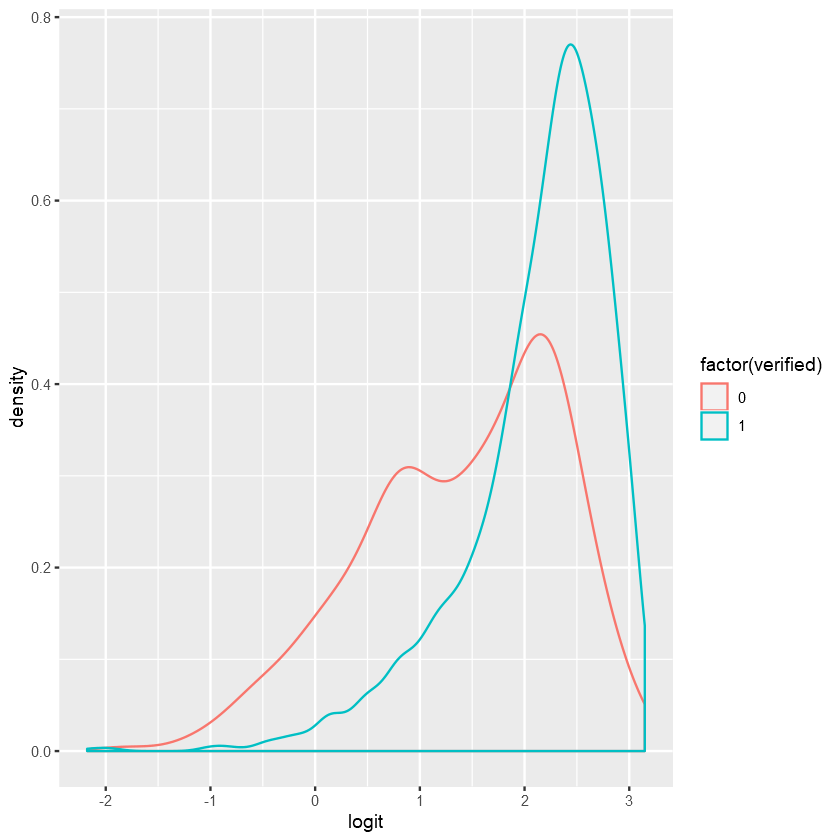

In [50]:
min_treat <- min( df[ df$verified == 1, ]$logit )
min_cont <- min( df[ df$verified == 0, ]$logit )
max_treat <- max( df[ df$verified == 1, ]$logit )
max_cont <- max( df[ df$verified == 0, ]$logit )
caliper <- 0.2 * sd( df$logit ) # Caliper set to 20% of the standard deviation
df <- df[ df$logit > max( min_treat, min_cont ) - caliper &
                        df$logit < min( max_treat, max_cont ) - caliper, ]

ggplot( df ) +
  geom_density( aes( x = logit, color = factor( verified ) ), alpha = 0.5 )


### Estimate effects: ATT estimate

In [51]:
treat_data <- df[ df$verified == 1, ]
treat_data$id <- seq( 1, nrow( treat_data ), by = 1 )
cont_data <- df[ df$verified == 0, ]
matched_data <- treat_data

In [52]:
# For every treated unit, find the matched unit with the closest logit value
for( i in 1:nrow( treat_data ) ) {
  logit_val <- treat_data[ i, ]$logit
  data_id <- treat_data[ i, ]$id
  closest <- min( abs( logit_val - cont_data$logit ) )
  index <- which( abs( logit_val - cont_data$logit ) == closest )
  match <- cont_data[ index[ 1 ], ]
  match$id <- data_id
  matched_data <- rbind( matched_data, match )
}

In [53]:
matched_data %>%
  group_by( id ) %>%
  arrange( verified ) %>%
  summarize( att = diff( vote_fillna ) ) %>%
  ungroup() %>%
  summarize( mean( att ) )

mean(att)
<dbl>
0.8632075


### Check balance

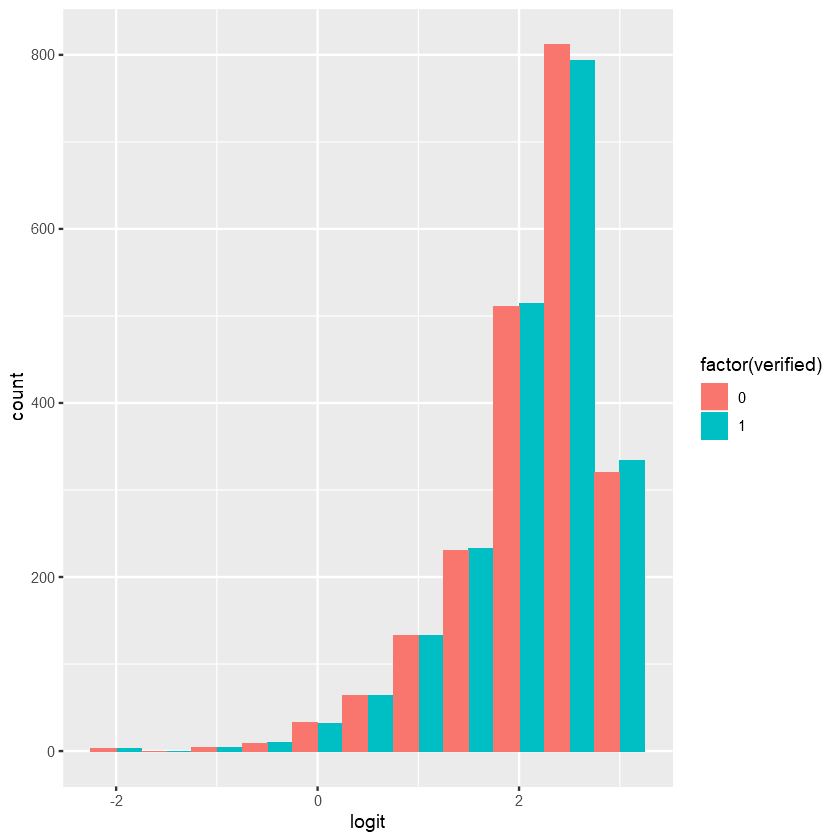

In [55]:
# Checking Balance on logit
ggplot( matched_data, aes( x = logit, fill = factor( verified ) ) ) +
  geom_histogram( binwidth = 0.5, position = "dodge" )

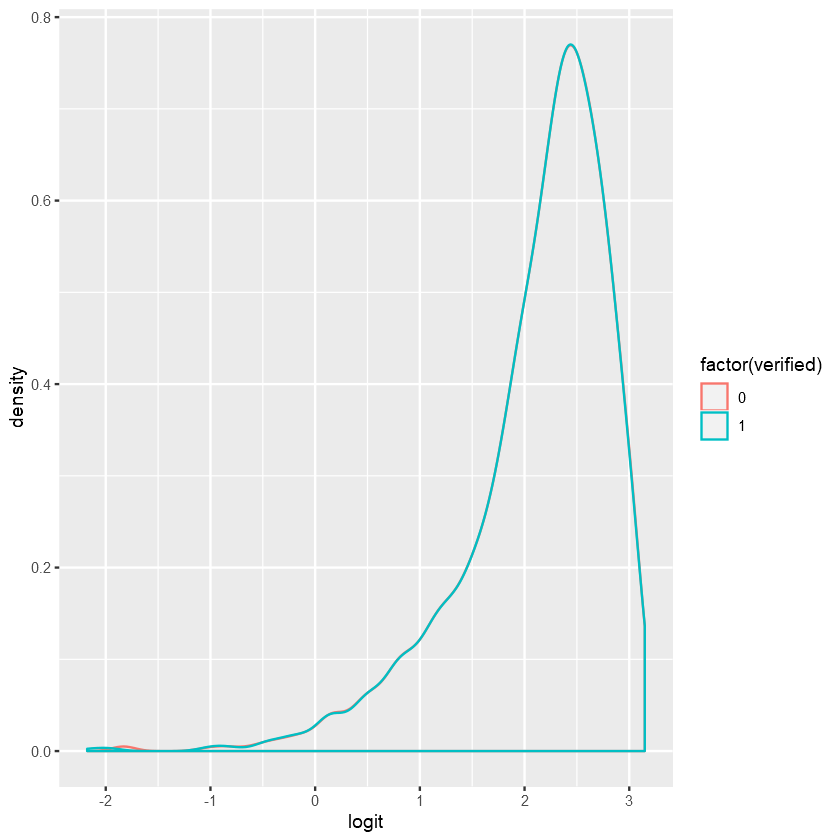

In [56]:
ggplot( matched_data, aes( x = logit, color = factor( verified ) ) ) +
  geom_density( alpha = 0.2 )

In [57]:
t.test( matched_data$logit ~ matched_data$verified )
summary( lm( logit ~ verified, data = matched_data ) )


	Welch Two Sample t-test

data:  matched_data$logit by matched_data$verified
t = 0.003381, df = 4238, p-value = 0.9973
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.04236992  0.04251631
sample estimates:
mean in group 0 mean in group 1 
       2.125428        2.125355 



Call:
lm(formula = logit ~ verified, data = matched_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.3032 -0.2936  0.1663  0.4884  1.0230 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.125e+00  1.531e-02 138.844   <2e-16 ***
verified    -7.319e-05  2.165e-02  -0.003    0.997    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7048 on 4238 degrees of freedom
Multiple R-squared:  2.697e-09,	Adjusted R-squared:  -0.000236 
F-statistic: 1.143e-05 on 1 and 4238 DF,  p-value: 0.9973


### Stratification

In [59]:
# Continue with our data with common support, but instead of matching, put into stratas
strata_quintile <- quantile( df$logit, probs = c( 0.2, 0.4, 0.6, 0.8 ) )
strata_data <- df %>%
  mutate( strata1 = as.numeric( logit <= strata_quintile[ 1 ] ),
          strata2 = as.numeric( logit > strata_quintile[ 1 ] & logit <= strata_quintile[ 2 ] ),
          strata3 = as.numeric( logit > strata_quintile[ 2 ] & logit <= strata_quintile[ 3 ] ),
          strata4 = as.numeric( logit > strata_quintile[ 3 ] & logit <= strata_quintile[ 4 ] ),
          strata5 = as.numeric( logit >= strata_quintile[ 4 ] ) )

# Checking Balance on logit
t.test( strata_data[ strata_data$strata1 == 1, ]$logit ~ strata_data[ strata_data$strata1 == 1, ]$verified ) # only one value!
t.test( strata_data[ strata_data$strata2 == 1, ]$logit ~ strata_data[ strata_data$strata2 == 1, ]$verified )
t.test( strata_data[ strata_data$strata3 == 1, ]$logit ~ strata_data[ strata_data$strata3 == 1, ]$verified )
t.test( strata_data[ strata_data$strata4 == 1, ]$logit ~ strata_data[ strata_data$strata4 == 1, ]$verified )
t.test( strata_data[ strata_data$strata5 == 1, ]$logit ~ strata_data[ strata_data$strata5 == 1, ]$verified )



	Welch Two Sample t-test

data:  strata_data[strata_data$strata1 == 1, ]$logit by strata_data[strata_data$strata1 == 1, ]$verified
t = -4.2389, df = 302.86, p-value = 2.986e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.3691905 -0.1350879
sample estimates:
mean in group 0 mean in group 1 
      0.5686976       0.8208369 



	Welch Two Sample t-test

data:  strata_data[strata_data$strata2 == 1, ]$logit by strata_data[strata_data$strata2 == 1, ]$verified
t = -1.5651, df = 89.755, p-value = 0.1211
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.078852273  0.009360296
sample estimates:
mean in group 0 mean in group 1 
       1.776912        1.811658 



	Welch Two Sample t-test

data:  strata_data[strata_data$strata3 == 1, ]$logit by strata_data[strata_data$strata3 == 1, ]$verified
t = -0.68331, df = 88.925, p-value = 0.4962
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.03238246  0.01580970
sample estimates:
mean in group 0 mean in group 1 
       2.214291        2.222577 



	Welch Two Sample t-test

data:  strata_data[strata_data$strata4 == 1, ]$logit by strata_data[strata_data$strata4 == 1, ]$verified
t = 0.17304, df = 28.542, p-value = 0.8638
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.03352209  0.03971396
sample estimates:
mean in group 0 mean in group 1 
       2.506599        2.503503 



	Welch Two Sample t-test

data:  strata_data[strata_data$strata5 == 1, ]$logit by strata_data[strata_data$strata5 == 1, ]$verified
t = -0.31001, df = 19.378, p-value = 0.7599
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.07743957  0.05743576
sample estimates:
mean in group 0 mean in group 1 
       2.838064        2.848066 


In [60]:
sum(strata_data$strata1);sum(strata_data$strata2);sum(strata_data$strata3)

[1] 494

[1] 494

[1] 494

In [65]:
summary( lm( vote_fillna ~ verified, data = filter( strata_data, strata2 == 1 ) ) )


Call:
lm(formula = vote_fillna ~ verified, data = filter(strata_data, 
    strata2 == 1))

Residuals:
    Min      1Q  Median      3Q     Max 
-0.1976 -0.1976 -0.1976 -0.1976 23.8024 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  0.11594    0.15065   0.770    0.442
verified     0.08171    0.16242   0.503    0.615

Residual standard error: 1.251 on 492 degrees of freedom
Multiple R-squared:  0.0005141,	Adjusted R-squared:  -0.001517 
F-statistic: 0.2531 on 1 and 492 DF,  p-value: 0.6152


In [31]:
summary( lm( vote_fillna ~ verified, data = filter( strata_data, strata3 == 1 ) ) )


Call:
lm(formula = vote_fillna ~ verified, data = filter(strata_data, 
    strata3 == 1))

Residuals:
    Min      1Q  Median      3Q     Max 
-0.0847 -0.0847 -0.0847 -0.0847  9.9153 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  0.05797    0.07174   0.808    0.419
verified     0.02673    0.07734   0.346    0.730

Residual standard error: 0.5959 on 492 degrees of freedom
Multiple R-squared:  0.0002428,	Adjusted R-squared:  -0.001789 
F-statistic: 0.1195 on 1 and 492 DF,  p-value: 0.7297


In [63]:
summary( lm( vote_fillna ~ verified, data = filter( strata_data, strata4 == 1 ) ) )


Call:
lm(formula = vote_fillna ~ verified, data = filter(strata_data, 
    strata4 == 1))

Residuals:
    Min      1Q  Median      3Q     Max 
-0.1111 -0.0321 -0.0321 -0.0321  3.9679 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  0.11111    0.06085   1.826   0.0685 .
verified    -0.07899    0.06258  -1.262   0.2075  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3162 on 492 degrees of freedom
Multiple R-squared:  0.003228,	Adjusted R-squared:  0.001202 
F-statistic: 1.593 on 1 and 492 DF,  p-value: 0.2075


In [66]:
# Effects including stratum
summary( lm( vote_fillna ~ verified + strata2 + strata3 + strata4 + strata5,
             data = strata_data ) )


Call:
lm(formula = vote_fillna ~ verified + strata2 + strata3 + strata4 + 
    strata5, data = strata_data)

Residuals:
    Min      1Q  Median      3Q     Max 
  -6.01   -0.42   -0.31   -0.07 1106.99 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)    4.358      1.470   2.964 0.003068 ** 
verified       1.656      1.476   1.122 0.261994    
strata2       -5.596      1.578  -3.548 0.000396 ***
strata3       -5.702      1.578  -3.614 0.000307 ***
strata4       -5.887      1.605  -3.667 0.000250 ***
strata5       -5.940      1.612  -3.686 0.000233 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 24.37 on 2464 degrees of freedom
Multiple R-squared:  0.008262,	Adjusted R-squared:  0.006249 
F-statistic: 4.105 on 5 and 2464 DF,  p-value: 0.001027
